In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES = 1


from batchflow import *
from batchflow.models.torch import *
from batchflow.models.torch.layers import *
from load_segment_dataset import Segmentation_dataset
from torch.optim import Adam
import torch
from model_learning import Train
import torch.nn.functional as F

env: CUDA_VISIBLE_DEVICES=1


In [2]:
DEVICE = 'cuda:0'

In [3]:
config = { 'inputs_shapes': (3, 256, 256),     
    'order': ['encoder', 'embedding', 'decoder', 'head'], 

    'encoder': {              
        'type': 'encoder',                                                   
        'num_stages': 4,  
        'order':['blocks', 'skip', 'downsample'],   
        'blocks':{'layout':'cna cna', 'channels':[64, 128, 256, 512]},   
        'downsample': {'layout': 'p', 'pool_size': 2, 'pool_stride': 2},
    },
    'embedding': {   
        'layout': 'cna cna',
        'channels': [1024, 1024], 
        'input_type': 'list',  
        'output_type': 'list',
        'input_index': -1,
    },
    'decoder': {
        'order':['upsample', 'combine', 'blocks'],
        'type': 'decoder',           
        'num_stages': 4,
        'blocks':{'layout':'cna cna', 'channels':['same // 2', 'same']},                                                     
        'upsample': {'layout': 't', 'kernel_size': 2, 'channels':'same // 2'},  
        'combine': {'op': 'concat'},   },             
        
    'head': {                     
        'layout': 'c', 
        'channels': 151,
        'kernel_size':1},
    'loss': 'ce',
    'device': DEVICE
    
}

model = TorchModel(config).model

In [4]:
print('parameters:', sum(param.numel() for param in model.parameters()))

parameters: 31046272


In [5]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

data = Segmentation_dataset(batch_size=4)
train_loader, val_loader, test_loader = data.get_loaders()
test_dataset, train_dataset = data.get_test_dataset()

optimizer = Adam(params=model.parameters(), lr=LEARNING_RATE)

In [6]:
def crop_images(predicted, masks_or_images):
    """Если выход больше или меньше чем исходное изображение,
    вырезать центральную часть из обоих, чтобы размеры совпадали.
    """
    if len(masks_or_images.shape) == 3:
        predicted, masks = crop_images(predicted, masks_or_images.unsqueeze(1))
        return predicted, masks[:, 0]
    images = masks_or_images
    if (len(predicted.shape) != 4) or (len(images.shape) != 4):
        raise ValueError("Expected tensors of shape BCHW")
    bi, ci, hi, wi = images.shape
    bp, cp, hp, wp = predicted.shape
    offset = (abs(hi - hp) // 2, abs(wi - wp) // 2)
    if hp < hi:
        images = images[:, :, offset[0]:offset[0] + hp]
    else:
        predicted = predicted[:, :, offset[0]:offset[0] + hi]
    if wp < wi:
        images = images[:, :, :, offset[1]:offset[1] + wp]
    else:
        predicted = predicted[:, :, :, offset[1]:offset[1] + wi]
    return predicted, images

class Crop_CE_Loss(torch.nn.Module):
    """Функция потерь для сегментации с несколькими классами."""
    def __init__(self):
        super().__init__()
        self._xent = torch.nn.CrossEntropyLoss()
        
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        predicted = predicted.permute(0, 2, 3, 1).reshape(b * h * w, c)
        masks = masks.reshape(-1)
        loss = self._xent(predicted, masks)
        return loss

In [7]:
loss_function = Crop_CE_Loss()

In [8]:
learning = Train(model=model, loss_function=loss_function,
                 optimizer=optimizer, num_epochs=NUM_EPOCHS, train_loader=train_loader,
                 val_loader=val_loader, test_loader=test_loader, test_dataset=test_dataset,
                 device=DEVICE)

In [9]:
learning.train_procedure(task='segmentation')

Epoch number is 1
Epoch number is 2
Epoch number is 3
Epoch number is 4
Epoch number is 5
Epoch number is 6
Epoch number is 7
Epoch number is 8
Epoch number is 9
Epoch number is 10


In [10]:
train_losses = learning.get_train_avg_loss()
valid_losses = learning.get_valid_avg_loss()

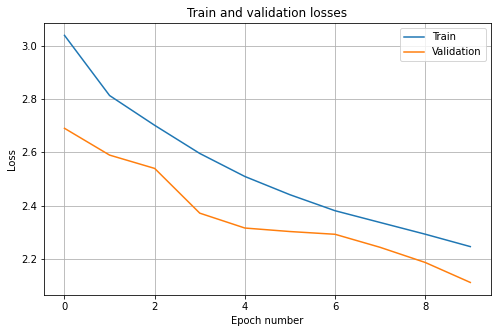

In [11]:
learning.plot_losses(train_losses=train_losses, valid_losses=valid_losses,
            fig_size_width=8, fig_size_height=5)

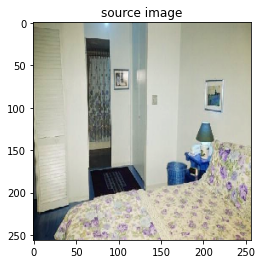

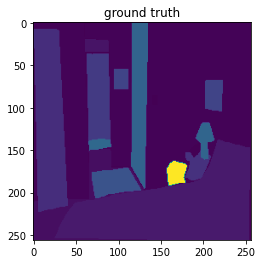

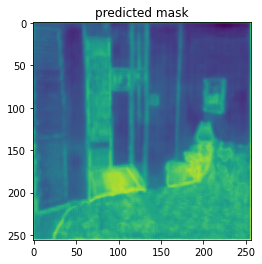

In [12]:
learning.predict_segmentation(idx=0)